In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statistics import mode
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import pyrsm as rsm
import datetime as dt
import timeit
import math
%matplotlib inline

In [2]:
df = pd.read_csv('project2_df2.csv').iloc[:,1:]
df_var = pd.read_csv('project2_vars_30.csv').iloc[:,1:]

In [3]:
df.shape

(96397, 568)

In [4]:
df_var.head()

,Variable
0,card_desc_total_3
1,card_state_max_30
2,card_state_total_7
3,card_zip_max_1
4,merch_desc_total_0


In [5]:
var = list(df_var.Variable)
df_model = df[var]
df_scaled = df_model.copy()
df_scaled = (df_model[var] - np.average(df_model[var])) / (np.std(df_model[var]))
df_scaled["Fraud"] = df.Fraud
df_scaled["Date"] = df.Date
df_scaled.head()

,card_desc_total_3,card_state_max_30,card_state_total_7,card_zip_max_1,merch_desc_total_0,card_desc_total_30,card_desc_total_14,Cardnum_total_0,merch_state_total_1,card_merch_max_1,...,merch_desc_total_1,merch_state_total_0,Merchnum_total_3,card_merch_total_30,merch_zip_max_0,card_zip_max_30,Cardnum_total_7,merch_desc_max_1,Fraud,Date
0,-0.217162,-0.678136,-0.207404,-0.869989,-0.310102,-0.204059,-0.211262,-0.256576,-0.201781,-0.871385,...,-0.202505,-0.309574,-0.154725,-0.204510,-0.882420,-0.809458,-0.122991,-0.778437,0,2010-01-01
1,-0.210305,-0.656723,-0.200855,-0.842519,-0.300310,-0.197615,-0.204591,-0.248475,-0.195409,-0.843870,...,-0.196111,-0.299799,-0.149840,-0.198053,-0.854557,-0.783899,-0.119107,-0.753858,0,2010-01-01
2,-0.174029,-0.543444,-0.166209,-0.697192,-0.248509,-0.163528,-0.169301,-0.205615,-0.161703,-0.698310,...,-0.162283,-0.248086,-0.123994,-0.163890,-0.707154,-0.648683,-0.098562,-0.623824,0,2010-01-01
3,-0.217162,-0.678136,-0.207404,-0.869989,-0.310102,-0.204059,-0.211262,-0.256576,-0.200951,-0.871385,...,-0.202505,-0.308301,-0.154089,-0.204510,-0.882420,-0.809458,-0.122991,-0.778437,0,2010-01-01
4,-0.216269,-0.678136,-0.206551,-0.869989,-0.308827,-0.203220,-0.210393,-0.255521,-0.200121,-0.871385,...,-0.201672,-0.307028,-0.153453,-0.203669,-0.882420,-0.809458,-0.122485,-0.778437,0,2010-01-01


In [6]:
# Split dataframe into 'model' and 'OOT'
model = df_scaled[(df_scaled.Date < '2010-09-01')]
OOT = df_scaled[(df_scaled.Date >= '2010-09-01')]
print(model.shape)
print(OOT.shape)

(69046, 32)
(27351, 32)


### Logistic Regression

In [7]:
x_trntst = model.iloc[:, :-2]
y_trntst = model[["Fraud"]]

x_oot = OOT.iloc[:, :-2]
y_oot = OOT[["Fraud"]]

nitermax = 10
FDR3 = pd.DataFrame(np.zeros((nitermax, 3)))
FDR3.columns = ['trn', 'tst', 'oot']
#FDR3

In [8]:
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(x_trntst, y_trntst, test_size = 0.3)
    model = LogisticRegression(penalty = 'l1',
                              C = 0.01,
                              solver = 'liblinear',
                              max_iter = 1000)
    
    X_trn_eval = X_trn.copy()
    X_tst_eval = X_tst.copy()
    X_oot_eval = x_oot.copy()
    
    model.fit(X_trn, Y_trn.values.ravel())
    
    predictions = model.predict_proba(X_trn)[:,1]
    X_trn_eval['predicted'] = predictions
    X_trn_eval["Fraud"] = Y_trn["Fraud"]
    topRows = int(round(X_trn_eval.shape[0]*0.03))
    temp = X_trn_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst_eval['predicted'] = predictions
    X_tst_eval["Fraud"] = Y_tst["Fraud"]
    topRows = int(round(X_tst_eval.shape[0]*0.03))
    temp = X_tst_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(x_oot)[:,1]
    X_oot_eval['predicted'] = predictions
    X_oot_eval["Fraud"] = y_oot["Fraud"]
    topRows = int(round(X_oot_eval.shape[0]*0.03))
    temp = X_oot_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot_eval.loc[:,'Fraud'])
    
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'], FDR3.loc[niter, 'oot'])
print(FDR3.mean())

0 0.656188605108055 0.634020618556701 0.4887640449438202
1 0.6333333333333333 0.695067264573991 0.4859550561797753
2 0.6418219461697723 0.6727272727272727 0.4887640449438202
3 0.6458333333333334 0.672645739910314 0.48314606741573035
4 0.6356435643564357 0.6818181818181818 0.4887640449438202
5 0.6459227467811158 0.6497890295358649 0.5
6 0.6352201257861635 0.6769911504424779 0.4943820224719101
7 0.6322314049586777 0.684931506849315 0.5028089887640449
8 0.6374745417515275 0.6839622641509434 0.4859550561797753
9 0.6473029045643154 0.6470588235294118 0.49157303370786515
trn    0.641097
tst    0.669901
oot    0.491011
dtype: float64


### Neural Network

In [26]:
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(x_trntst, y_trntst, test_size = 0.3)
    model = MLPClassifier(hidden_layer_sizes = (10),
                         activation = 'tanh',
                         max_iter = 200,
                         alpha = 0.0001,
                         solver = 'adam')
    
    X_trn_array = X_trn.values
    X_tst_array = X_tst.values
    X_oot_array = x_oot.values
    Y_trn_array = Y_trn.values
    Y_tst_array = Y_tst.values
    Y_oot_array = y_oot.values
    
    X_trn_eval = X_trn.copy()
    X_tst_eval = X_tst.copy()
    X_oot_eval = x_oot.copy()
    
    model.fit(X_trn, Y_trn.values.ravel())
    
    predictions = model.predict_proba(X_trn)[:,1]
    X_trn_eval['predicted'] = predictions
    X_trn_eval["Fraud"] = Y_trn["Fraud"]
    topRows = int(round(X_trn_eval.shape[0]*0.03))
    temp = X_trn_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst_eval['predicted'] = predictions
    X_tst_eval["Fraud"] = Y_tst["Fraud"]
    topRows = int(round(X_tst_eval.shape[0]*0.03))
    temp = X_tst_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(x_oot)[:,1]
    X_oot_eval['predicted'] = predictions
    X_oot_eval["Fraud"] = y_oot["Fraud"]
    topRows = int(round(X_oot_eval.shape[0]*0.03))
    temp = X_oot_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot_eval.loc[:,'Fraud'])
    
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'], FDR3.loc[niter, 'oot'])
print(FDR3.mean())

0 0.8153526970954357 0.7963800904977375 0.6376404494382022
1 0.8117408906882592 0.7416267942583732 0.601123595505618
2 0.8273092369477911 0.6829268292682927 0.5926966292134831
3 0.8197064989517819 0.7964601769911505 0.6264044943820225
4 0.7786561264822134 0.6954314720812182 0.6067415730337079
5 0.7965451055662188 0.8131868131868132 0.5814606741573034
6 0.8330019880715706 0.785 0.5702247191011236
7 0.8112449799196787 0.8048780487804879 0.6095505617977528
8 0.8433268858800773 0.7741935483870968 0.5674157303370787
9 0.8117647058823529 0.8238341968911918 0.6235955056179775
trn    0.814865
tst    0.771392
oot    0.601685
dtype: float64


### RandomForest

In [23]:
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(x_trntst, y_trntst, test_size = 0.3)
    
    model = RandomForestClassifier(n_estimators = 30,
                                  max_depth = None,
                                  max_features = 5,
                                  min_samples_leaf = 1,
                                  min_samples_split = 2)
    
    X_trn_eval = X_trn.copy()
    X_tst_eval = X_tst.copy()
    X_oot_eval = x_oot.copy()
    
    model.fit(X_trn, Y_trn.values.ravel())
    
    predictions = model.predict_proba(X_trn)[:,1]
    X_trn_eval['predicted'] = predictions
    X_trn_eval["Fraud"] = Y_trn["Fraud"]
    topRows = int(round(X_trn_eval.shape[0]*0.03))
    temp = X_trn_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst_eval['predicted'] = predictions
    X_tst_eval["Fraud"] = Y_tst["Fraud"]
    topRows = int(round(X_tst_eval.shape[0]*0.03))
    temp = X_tst_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(x_oot)[:,1]
    X_oot_eval['predicted'] = predictions
    X_oot_eval["Fraud"] = y_oot["Fraud"]
    topRows = int(round(X_oot_eval.shape[0]*0.03))
    temp = X_oot_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot_eval.loc[:,'Fraud'])
    
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'], FDR3.loc[niter, 'oot'])
print(FDR3.mean())

0 1.0 0.8868778280542986 0.6292134831460674
1 1.0 0.8951965065502183 0.6432584269662921
2 1.0 0.8790697674418605 0.6404494382022472
3 1.0 0.8599033816425121 0.6292134831460674
4 1.0 0.8669724770642202 0.6264044943820225
5 1.0 0.8170212765957446 0.6235955056179775
6 1.0 0.8557692307692307 0.6432584269662921
7 1.0 0.8930232558139535 0.6207865168539326
8 1.0 0.8676470588235294 0.6095505617977528
9 1.0 0.8634146341463415 0.6207865168539326
trn    1.000000
tst    0.868490
oot    0.628652
dtype: float64


### Gradient Boosting

In [21]:
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(x_trntst, y_trntst, test_size = 0.3)
    
    model = GradientBoostingClassifier(learning_rate = 0.01,
                                      n_estimators = 50,
                                      max_depth = 3,
                                      max_features = None,
                                      min_samples_leaf = 1,
                                      min_samples_split = 2)
    
    X_trn_eval = X_trn.copy()
    X_tst_eval = X_tst.copy()
    X_oot_eval = x_oot.copy()
    
    model.fit(X_trn, Y_trn.values.ravel())
    
    predictions = model.predict_proba(X_trn)[:,1]
    X_trn_eval['predicted'] = predictions
    X_trn_eval["Fraud"] = Y_trn["Fraud"]
    topRows = int(round(X_trn_eval.shape[0]*0.03))
    temp = X_trn_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst_eval['predicted'] = predictions
    X_tst_eval["Fraud"] = Y_tst["Fraud"]
    topRows = int(round(X_tst_eval.shape[0]*0.03))
    temp = X_tst_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(x_oot)[:,1]
    X_oot_eval['predicted'] = predictions
    X_oot_eval["Fraud"] = y_oot["Fraud"]
    topRows = int(round(X_oot_eval.shape[0]*0.03))
    temp = X_oot_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot_eval.loc[:,'Fraud'])
    
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'], FDR3.loc[niter, 'oot'])
print(FDR3.mean())

0 0.7465346534653465 0.6717171717171717 0.5
1 0.6952965235173824 0.6214953271028038 0.5561797752808989
2 0.6794354838709677 0.714975845410628 0.5252808988764045
3 0.7178947368421053 0.7149122807017544 0.5533707865168539
4 0.7391304347826086 0.6954314720812182 0.5617977528089888
5 0.7270875763747454 0.7075471698113207 0.5561797752808989
6 0.7105263157894737 0.6698564593301436 0.5056179775280899
7 0.6894409937888198 0.6636363636363637 0.5224719101123596
8 0.684322033898305 0.683982683982684 0.547752808988764
9 0.7261904761904762 0.6934673366834171 0.5308988764044944
trn    0.711586
tst    0.683702
oot    0.535955
dtype: float64


### XGBoost

In [8]:
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(x_trntst, y_trntst, test_size = 0.3)
    
    model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 6, min_child_weight = 5)
    
    X_trn_eval = X_trn.copy()
    X_tst_eval = X_tst.copy()
    X_oot_eval = x_oot.copy()
    
    model.fit(X_trn, Y_trn.values.ravel())
    
    predictions = model.predict_proba(X_trn)[:,1]
    X_trn_eval['predicted'] = predictions
    X_trn_eval["Fraud"] = Y_trn["Fraud"]
    topRows = int(round(X_trn_eval.shape[0]*0.03))
    temp = X_trn_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst_eval['predicted'] = predictions
    X_tst_eval["Fraud"] = Y_tst["Fraud"]
    topRows = int(round(X_tst_eval.shape[0]*0.03))
    temp = X_tst_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions = model.predict_proba(x_oot)[:,1]
    X_oot_eval['predicted'] = predictions
    X_oot_eval["Fraud"] = y_oot["Fraud"]
    topRows = int(round(X_oot_eval.shape[0]*0.03))
    temp = X_oot_eval.sort_values('predicted', ascending = False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot_eval.loc[:,'Fraud'])
    
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'], FDR3.loc[niter, 'oot'])
print(FDR3.mean())

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:58:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0 0.9272727272727272 0.9134615384615384 0.6348314606741573
[11:58:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1 0.9294605809128631 0.9049773755656109 0.6179775280898876
[11:58:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2 0.9476987447698745 0.8888888888888888 0.6292134831460674
[11:58:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3

-----

### Final_Model

In [14]:
#X_trn_eval = pd.read_csv("train.csv").iloc[:,1:]
#X_tst_eval = pd.read_csv("test.csv").iloc[:,1:]
#X_oot_eval = pd.read_csv("oot.csv").iloc[:,1:]

In [9]:
X_trn_eval

,card_desc_total_3,card_state_max_30,card_state_total_7,card_zip_max_1,merch_desc_total_0,card_desc_total_30,card_desc_total_14,Cardnum_total_0,merch_state_total_1,card_merch_max_1,...,merch_desc_total_1,merch_state_total_0,Merchnum_total_3,card_merch_total_30,merch_zip_max_0,card_zip_max_30,Cardnum_total_7,merch_desc_max_1,predicted,Fraud
3255,-0.097948,-0.305864,-0.093547,-0.392397,0.008558,-0.092038,-0.095287,-0.115725,0.074702,-0.393027,...,0.074970,0.008543,0.486127,-0.092242,-0.398004,-0.365095,-0.055473,-0.351104,0.001718,0
54467,-0.208436,-0.375717,-0.140447,-0.835029,-0.297640,-0.195858,-0.202773,-0.205382,-0.193672,-0.836368,...,-0.194367,-0.297134,-0.148508,-0.196292,-0.846960,-0.776930,-0.014874,-0.747156,0.000567,0
47358,-0.012405,-0.173530,-0.011848,-0.700640,-0.249739,-0.011657,-0.012068,-0.206632,-0.162503,-0.701764,...,-0.163086,-0.249313,0.141078,-0.011682,-0.710652,-0.207134,0.229845,-0.626910,0.009574,0
29773,-0.208201,-0.611641,-0.177656,-0.834090,-0.297306,-0.159275,-0.180961,-0.245989,-0.193454,-0.835428,...,-0.194149,-0.296800,-0.148341,-0.159628,-0.846008,-0.730086,-0.033547,-0.746316,0.000420,0
55837,-0.143072,-0.406211,-0.052623,-0.573169,-0.204302,-0.134439,-0.139184,-0.169038,-0.132938,-0.574089,...,-0.133415,-0.203955,-0.101937,-0.134736,-0.581359,-0.533290,-0.031206,-0.512853,0.000972,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16970,-0.216269,-0.659357,-0.204822,-0.869989,-0.310102,-0.203220,-0.210393,-0.256576,-0.180831,-0.871385,...,-0.198592,-0.309574,0.023181,-0.196896,-0.882420,-0.787043,0.172138,-0.769799,0.000179,0
49603,1.802062,1.206159,1.721086,1.547398,2.573298,3.330553,1.753102,2.624550,1.674423,1.549880,...,1.680432,2.568916,1.283946,3.337923,1.569508,1.439734,1.258085,1.384560,0.061125,0
15133,-0.077461,2.156533,1.097110,-0.310322,-0.110612,-0.072787,-0.075356,-0.091520,-0.071974,-0.310819,...,-0.072233,-0.110424,-0.055190,-0.072948,-0.314756,-0.288730,0.650586,-0.277665,0.033445,0
11560,-0.204447,-0.427901,-0.195260,-0.819050,-0.233026,-0.056558,-0.120067,-0.241553,-0.095363,-0.820364,...,-0.095705,-0.232629,-0.024796,-0.056683,-0.718389,-0.510764,0.015099,-0.564576,0.000127,0


In [10]:
## define a function to create the final dataframe for training/test/OOT set

def final_table_report(dataset):
    final_df = dataset.groupby("Bins")["Fraud"].count().to_frame()
    final_df.columns = ["# Records"]
    final_df["# Bads"] = dataset.groupby("Bins")["Fraud"].sum()
    final_df["# Goods"] = final_df["# Records"] - final_df["# Bads"]
    final_df["% Bads"] = final_df["# Bads"] / final_df["# Records"]
    final_df["% Goods"] = final_df["# Goods"] / final_df["# Records"]
    final_df["Total # Records"] = np.cumsum(final_df["# Records"])
    final_df["Cumulative Bad"] = np.cumsum(final_df["# Bads"])
    final_df["Cumulative Good"] = np.cumsum(final_df["# Goods"])
    final_df["% Bad(FDR)"] = final_df["Cumulative Bad"] / final_df["# Bads"].sum()
    final_df["% Good"] = final_df["Cumulative Good"] / final_df["# Goods"].sum()
    final_df["KS"] = final_df["% Bad(FDR)"] - final_df["% Good"]
    final_df["FPR"] = final_df["Cumulative Good"] / final_df["Cumulative Bad"]
    return(final_df)

#### Training set

In [11]:
## Training set statistics
print("# Records:", len(X_trn_eval))
print("# Bads:", X_trn_eval.Fraud.sum())
print("# Goods:", len(X_trn_eval) - X_trn_eval.Fraud.sum())

# Records: 48332
# Bads: 494
# Goods: 47838


In [12]:
## Get 20% of the population
trn = X_trn_eval.copy()
trn = trn.sort_values("predicted", ascending = False)
trn = trn.assign(Bins = rsm.xtile(trn["predicted"], 100, rev=True))

In [13]:
## Get the final table for training set
trn_df = final_table_report(trn)
trn_df.head(20)

,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Bad,Cumulative Good,% Bad(FDR),% Good,KS,FPR
Bins,,,,,,,,,,,,
1,484,422,62,0.871901,0.128099,484,422,62,0.854251,0.001296,0.852955,0.146919
2,483,28,455,0.057971,0.942029,967,450,517,0.910931,0.010807,0.900124,1.148889
3,483,11,472,0.022774,0.977226,1450,461,989,0.933198,0.020674,0.912524,2.145336
4,484,1,483,0.002066,0.997934,1934,462,1472,0.935223,0.030771,0.904452,3.186147
5,483,4,479,0.008282,0.991718,2417,466,1951,0.943320,0.040783,0.902536,4.186695
6,483,6,477,0.012422,0.987578,2900,472,2428,0.955466,0.050755,0.904711,5.144068
7,484,2,482,0.004132,0.995868,3384,474,2910,0.959514,0.060830,0.898684,6.139241
8,483,2,481,0.004141,0.995859,3867,476,3391,0.963563,0.070885,0.892678,7.123950
9,483,4,479,0.008282,0.991718,4350,480,3870,0.971660,0.080898,0.890762,8.062500


#### Test set

In [14]:
## Test set statistics
print("# Records:", len(X_tst_eval))
print("# Bads:", X_tst_eval.Fraud.sum())
print("# Goods:", len(X_tst_eval) - X_tst_eval.Fraud.sum())

# Records: 20714
# Bads: 209
# Goods: 20505


In [15]:
## Get 20% of the population
tst = X_tst_eval.copy()
tst = tst.sort_values("predicted", ascending = False)
tst = tst.assign(Bins = rsm.xtile(tst["predicted"], 100, rev=True))

In [16]:
## Get the final table for test set
tst_df = final_table_report(tst)
tst_df.head(20)

,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Bad,Cumulative Good,% Bad(FDR),% Good,KS,FPR
Bins,,,,,,,,,,,,
1,208,153,55,0.735577,0.264423,208,153,55,0.732057,0.002682,0.729375,0.359477
2,207,26,181,0.125604,0.874396,415,179,236,0.856459,0.011509,0.844950,1.318436
3,207,8,199,0.038647,0.961353,622,187,435,0.894737,0.021214,0.873523,2.326203
4,207,1,206,0.004831,0.995169,829,188,641,0.899522,0.031261,0.868261,3.409574
5,207,2,205,0.009662,0.990338,1036,190,846,0.909091,0.041258,0.867833,4.452632
6,206,4,202,0.019417,0.980583,1242,194,1048,0.928230,0.051109,0.877120,5.402062
7,208,1,207,0.004808,0.995192,1450,195,1255,0.933014,0.061205,0.871810,6.435897
8,208,0,208,0.000000,1.000000,1658,195,1463,0.933014,0.071348,0.861666,7.502564
9,207,0,207,0.000000,1.000000,1865,195,1670,0.933014,0.081444,0.851571,8.564103


#### OOT set

In [17]:
## OOT set statistics
print("# Records:", len(X_oot_eval))
print("# Bads:", X_oot_eval.Fraud.sum())
print("# Goods:", len(X_oot_eval) - X_oot_eval.Fraud.sum())

# Records: 27351
# Bads: 356
# Goods: 26995


In [18]:
## Get 20% of the population
OOT = X_oot_eval.copy()
OOT = OOT.sort_values("predicted", ascending = False)
OOT = OOT.assign(Bins = rsm.xtile(OOT["predicted"], 100, rev=True))

In [19]:
## Get the final table for OOT set
OOT_df = final_table_report(OOT)
OOT_df.head(20)

,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Bad,Cumulative Good,% Bad(FDR),% Good,KS,FPR
Bins,,,,,,,,,,,,
1,274,161,113,0.587591,0.412409,274,161,113,0.452247,0.004186,0.448061,0.701863
2,273,48,225,0.175824,0.824176,547,209,338,0.587079,0.012521,0.574558,1.617225
3,274,15,259,0.054745,0.945255,821,224,597,0.629213,0.022115,0.607098,2.665179
4,273,15,258,0.054945,0.945055,1094,239,855,0.671348,0.031673,0.639676,3.577406
5,274,10,264,0.036496,0.963504,1368,249,1119,0.699438,0.041452,0.657986,4.493976
6,273,9,264,0.032967,0.967033,1641,258,1383,0.724719,0.051232,0.673487,5.360465
7,274,7,267,0.025547,0.974453,1915,265,1650,0.744382,0.061122,0.683260,6.226415
8,273,8,265,0.029304,0.970696,2188,273,1915,0.766854,0.070939,0.695915,7.014652
9,274,9,265,0.032847,0.967153,2462,282,2180,0.792135,0.080756,0.711379,7.730496


In [20]:
## export to xlsx file
from openpyxl import Workbook
with pd.ExcelWriter('final_model_report_ver2.xlsx') as writer:  
    trn_df.head(20).to_excel(writer, sheet_name='training')
    tst_df.head(20).to_excel(writer, sheet_name='test')
    OOT_df.head(20).to_excel(writer, sheet_name='OOT')

### Fraud Savings

We recommend a score cutoff at 9 % with an expected annual savings of 1365000



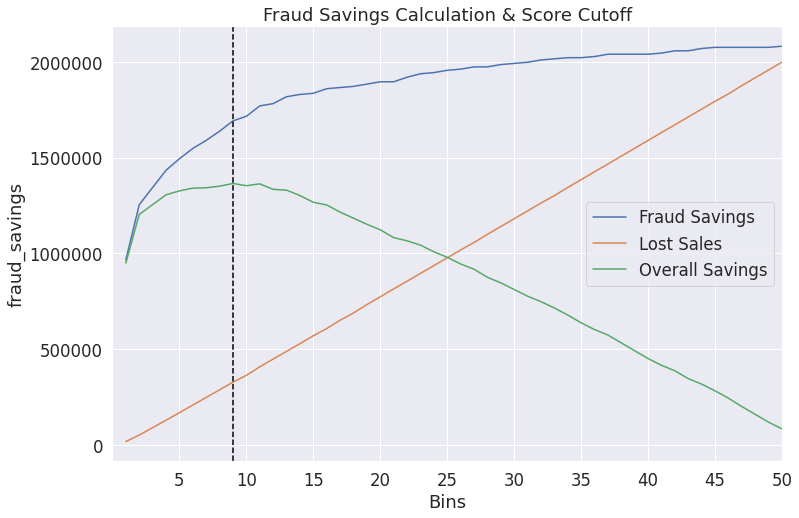

In [21]:
## Assume $2000 gain for every fraud that’s caught
## Assume $100 loss for every false positive (a good that’s flagged as a bad)
## Calculate the Fraud Savings, Lost Sales, Overall Savings
## The plot indicates expected annual savings

OOT_df_copy = OOT_df.copy().reset_index().head(50)

fraud_gain = 2000
fp_loss = 50
OOT_df_copy["fraud_savings"] = OOT_df_copy["Cumulative Bad"] * fraud_gain * 3
OOT_df_copy["lost_sales"] = OOT_df_copy["Cumulative Good"] * fp_loss* 3
OOT_df_copy["overall_saving"] = OOT_df_copy["fraud_savings"] - OOT_df_copy["lost_sales"]
optimal_index = np.where(OOT_df_copy.overall_saving == OOT_df_copy.overall_saving.max())[0][0]
optimal_bin = OOT_df_copy.loc[optimal_index, "Bins"]

plt.rcParams["figure.figsize"] = [12,8]
sns.set(font_scale=1.5)
plt.xlim([0, 20])
plt.xticks((5,10,15,20,25,30,35,40,45,50))
plot = sns.lineplot(data=OOT_df_copy, x="Bins", y="fraud_savings")
plot = sns.lineplot(data=OOT_df_copy, x="Bins", y="lost_sales")
plot = sns.lineplot(data=OOT_df_copy, x="Bins", y="overall_saving")
plot.legend(['Fraud Savings', 'Lost Sales', 'Overall Savings'])
plot.axvline(x = optimal_bin, color = 'black', linestyle = '--')
plt.title("Fraud Savings Calculation & Score Cutoff")
plt.ticklabel_format(style='plain')

optimal_saving = int(OOT_df_copy[OOT_df_copy.Bins == optimal_bin]["Cumulative Bad"] * fraud_gain * 3) - int(OOT_df_copy[OOT_df_copy.Bins == optimal_bin]["Cumulative Good"] * fp_loss * 3)
print("We recommend a score cutoff at", optimal_bin, "% with an expected annual savings of", optimal_saving)
print("")

### Fraud Scores Examples

#### Cardnum = 5142235211

In [24]:
OOT_all = df.copy().iloc[X_oot_eval.index, :]
OOT_all["predicted"] = X_oot_eval.predicted
OOT_all.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_desc_count_1_by_7,card_desc_count_1_by_14,card_desc_count_1_by_30,merch_desc_count_0_by_7,merch_desc_count_0_by_14,merch_desc_count_0_by_30,merch_desc_count_1_by_7,merch_desc_count_1_by_14,merch_desc_count_1_by_30,predicted
69046,69296,5142121708,2010-09-01,3830819800365,STAR OFFICE PRODUCTS INC,DC,20006,P,622.20,0,...,0.142857,0.071429,0.033333,0.035714,0.017857,0.003704,0.035714,0.017857,0.003704,0.000943
69047,69297,5142211606,2010-09-01,679076000817,LOYOLA BLAKEFIELD,MD,21204,P,350.00,0,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.000565
69048,69298,5142124669,2010-09-01,9900000034106,GSA/CUST SUPPLY CTR 94,PA,19107,P,23.77,0,...,0.071429,0.035714,0.016667,0.028571,0.005952,0.001389,0.057143,0.011905,0.002778,0.000727
69049,69299,5142210384,2010-09-01,400004090307,VISION COMPUTER WORKS,CA,90291,P,566.28,0,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.016667,0.142857,0.071429,0.016667,0.001692
69050,69300,5142230181,2010-09-01,465616626335,OXFORD UNIV PRESS,NC,27513,P,60.75,0,...,0.142857,0.071429,0.033333,0.071429,0.035714,0.006667,0.071429,0.035714,0.006667,0.001045


In [25]:
## groupby 'Cardnum' and check the top mean fraud score
OOT_all.groupby("Cardnum")["predicted"].mean().sort_values(ascending=False).head(10)

Cardnum
5142294097    0.730408
5142112858    0.673321
5142220919    0.470541
5142235211    0.467741
5142273038    0.464509
5142228988    0.372775
5142288601    0.370439
5142217059    0.343542
5142183973    0.298079
5142299705    0.199363
Name: predicted, dtype: float32

In [26]:
## Select a good example of fraud
cardnum = 5142235211
cardnum_score = OOT_all[OOT_all.Cardnum == cardnum].groupby("Date")["predicted"].mean().to_frame().reset_index()
counts = OOT_all[OOT_all.Cardnum == cardnum].groupby("Date")["Recnum"].count().to_frame().reset_index()
counts.columns = ["Date", "num_transactions"]
cardnum_score = cardnum_score.merge(counts)
cardnum_score["cum_transactions"] = np.cumsum(cardnum_score["num_transactions"])
cardnum_score

,Date,predicted,num_transactions,cum_transactions
0,2010-09-09,0.000742,2,2
1,2010-09-19,0.000737,1,3
2,2010-09-27,0.000764,1,4
3,2010-11-17,0.001102,1,5
4,2010-11-25,0.387643,17,22
5,2010-11-26,0.744890,15,37
6,2010-12-01,0.006804,1,38


Text(0, 0.5, 'Fraud Score')

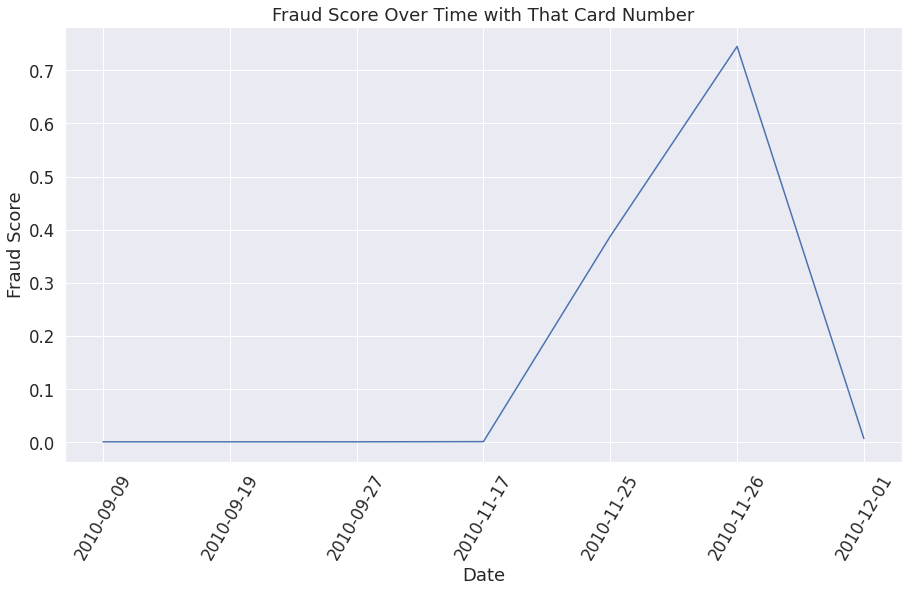

In [37]:
plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
plt.xticks(rotation=60)
plot = sns.lineplot(data=cardnum_score, x="Date", y="predicted")
plt.title("Fraud Score Over Time with That Card Number")
plt.xlabel("Date")
plt.ylabel("Fraud Score")

<ipython-input-35-2ebf10c63925>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardnum_fraud["#transaction"] = 1
<ipython-input-35-2ebf10c63925>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardnum_fraud["#transaction"] = np.cumsum(cardnum_fraud["#transaction"])


Text(0, 0.5, 'Fraud Score')

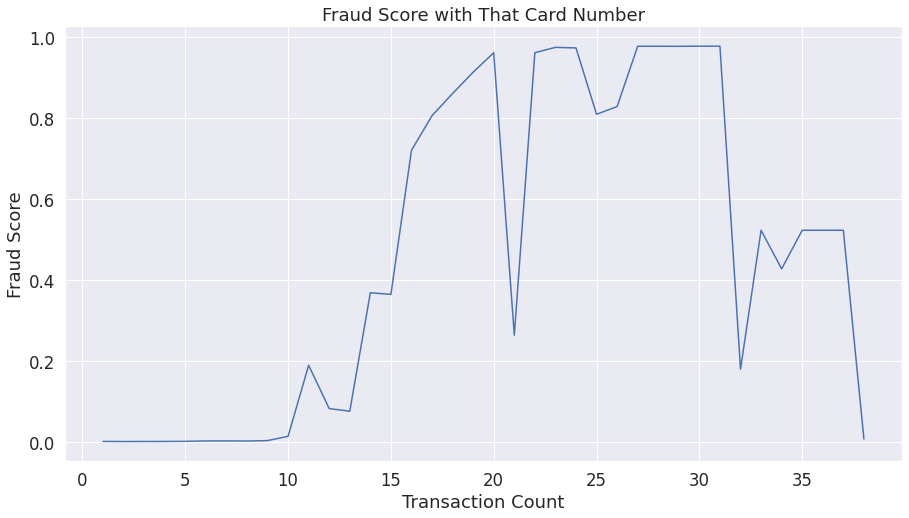

In [35]:
cardnum_fraud = OOT_all[OOT_all.Cardnum == cardnum]
cardnum_fraud["#transaction"] = 1
cardnum_fraud["#transaction"] = np.cumsum(cardnum_fraud["#transaction"])
plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
plot = sns.lineplot(data=cardnum_fraud, x="#transaction", y="predicted")
plt.title("Fraud Score with That Card Number")
plt.xlabel("Transaction Count")
plt.ylabel("Fraud Score")

#### Merchnum = "6005030600003"

In [30]:
## Select a good example of fraud
merchnum = "6005030600003"
merchnum_score = OOT_all[OOT_all.Merchnum == merchnum].groupby("Date")["predicted"].mean().to_frame().reset_index()
merchnum_score
counts = OOT_all[OOT_all.Merchnum == merchnum].groupby("Date")["Recnum"].count().to_frame().reset_index()
counts.columns = ["Date", "num_transactions"]
merchnum_score = merchnum_score.merge(counts)
merchnum_score["cum_transactions"] = np.cumsum(merchnum_score["num_transactions"])
merchnum_score

,Date,predicted,num_transactions,cum_transactions
0,2010-09-21,0.000387,1,1
1,2010-09-27,0.106253,2,3
2,2010-10-04,0.002048,1,4
3,2010-10-07,0.791723,24,28
4,2010-11-11,0.000636,1,29
5,2010-11-19,0.004041,1,30
6,2010-12-08,0.000213,1,31
7,2010-12-29,0.000481,1,32


Text(0, 0.5, 'Fraud Score')

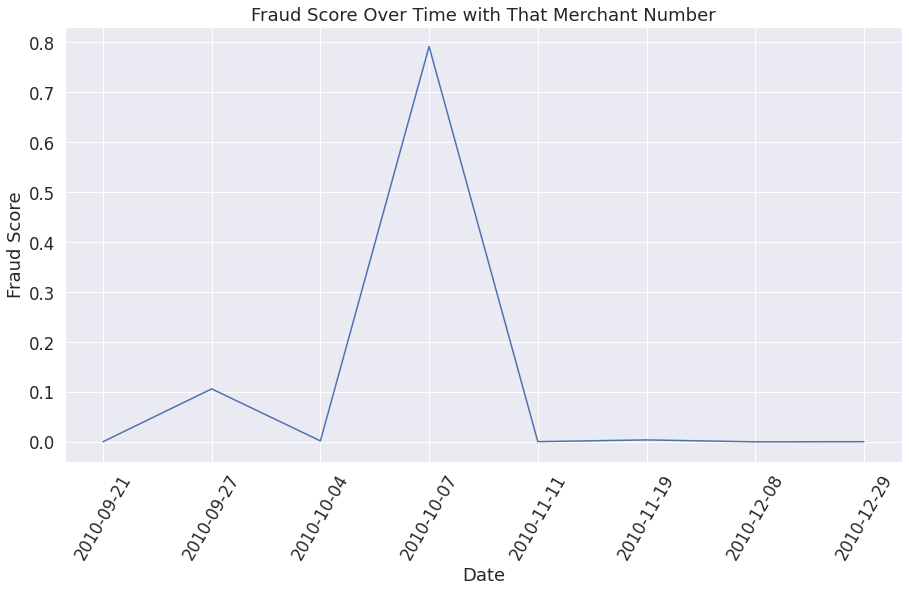

In [36]:
plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
plt.xticks(rotation=60)
plot = sns.lineplot(data=merchnum_score, x="Date", y="predicted")
plt.title("Fraud Score Over Time with That Merchant Number")
plt.xlabel("Date")
plt.ylabel("Fraud Score")

<ipython-input-38-76685279a152>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchnum_fraud["#transaction"] = 1
<ipython-input-38-76685279a152>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchnum_fraud["#transaction"] = np.cumsum(merchnum_fraud["#transaction"])


Text(0, 0.5, 'Fraud Score')

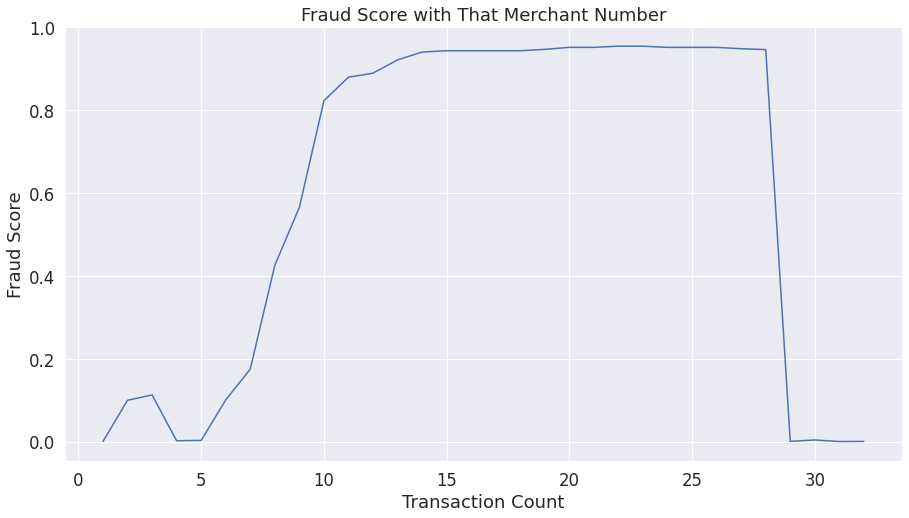

In [38]:
merchnum_fraud = OOT_all[OOT_all.Merchnum == merchnum]
merchnum_fraud["#transaction"] = 1
merchnum_fraud["#transaction"] = np.cumsum(merchnum_fraud["#transaction"])
plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
plot = sns.lineplot(data=merchnum_fraud, x="#transaction", y="predicted")
plt.title("Fraud Score with That Merchant Number")
plt.xlabel("Transaction Count")
plt.ylabel("Fraud Score")